In [1]:
%matplotlib inline

In [2]:
import rfpipe
import numpy as np 
import pylab as plt

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
def make_dmt(ft, dmi, dmf, dmsteps, chan_freqs, tsamp):
    dm_list = np.linspace(dmi, dmf, dmsteps)
    dmt = np.zeros((dmsteps, ft.shape[1]), dtype=np.float32)
    for ii, dm in enumerate(dm_list):
        dmt[ii, :] = dedispersedts(ft, chan_freqs, tsamp, dms=dm)
    return dmt

def dedispersedts(data, chan_freqs, tsamp, dms=None):
    nf, nt = data.shape
    assert nf == len(chan_freqs)
    delay_time = 4148808.0 * dms * (1 / (chan_freqs[0]) ** 2 - 1 / (chan_freqs) ** 2) / 1000
    delay_bins = np.round(delay_time / tsamp).astype('int64')
    ts = np.zeros(nt, dtype=np.float32)
    for ii in range(nf):
        ts += np.concatenate([data[ii,-delay_bins[ii]:], data[ii, :-delay_bins[ii]]])
    return ts

def dedisperse(data, chan_freqs, tsamp, dms=None):
    nf, nt = data.shape
    assert nf == len(chan_freqs)
    delay_time = 4148808.0 * dms * (1 / (chan_freqs[0]) ** 2 - 1 / (chan_freqs) ** 2) / 1000
    delay_bins = np.round(delay_time / tsamp).astype('int64')
    ft = np.zeros(data.shape, dtype=np.float32)
    for ii in range(nf):
        ft[ii, :] = np.concatenate([data[ii,-delay_bins[ii]:], data[ii, :-delay_bins[ii]]])
    return ft

def make_refinement_plots(cd, nsubbands = 4):
    dtarr_ind = cd.loc[3]
    width_m = cd.state.dtarr[dtarr_ind]
    timewindow = cd.state.prefs.timewindow
    tsamp = cd.state.inttime*width_m
    dm = cd.state.dmarr[cd.loc[2]]
    ft_dedisp = np.flip(np.abs(cd.data[:,:,0].T) + np.abs(cd.data[:,:,1].T), axis=0)
    chan_freqs = np.flip(cd.state.freq*1000, axis=0) #from high to low, MHz
    nf, nt = np.shape(ft_dedisp)

    if nt != timewindow:
        timewindow = nt
    
    dispersed = dedisperse(ft_dedisp, chan_freqs, tsamp, -1*dm)
    dmt = make_dmt(dispersed, 0, 2*dm, 256, chan_freqs, tsamp)
    subsnrs, bandstarts, subts = calc_subband_info(ft_dedisp, nsubbands)

    print(f'candloc: {cd.loc}, dm: {dm}')
    print(f'Subbanded SNRs are:')    
    for i in range(nsubbands):
        print(f'Band: {chan_freqs[bandstarts[i]]:.2f}-{chan_freqs[bandstarts[i]+nf//nsubbands-1]:.2f}, SNR: {subsnrs[i]}')
    ts = np.arange(timewindow)*tsamp
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (10,15), sharex=True)
    for i in range(nsubbands):
        ax[0].plot(ts, subts[i] - subts[i].mean(), label = f'Band: {chan_freqs[bandstarts[i]]:.0f}-{chan_freqs[bandstarts[i]+nf//nsubbands-1]:.0f}')
    ax[0].plot(ts, subts.sum(0) - subts.sum(0).mean(), 'k.', label = 'Full Band')
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True)
    ax[0].set_ylabel('Flux (Arb. units)')
    ax[1].imshow(ft_dedisp, aspect='auto', extent=[ts[0], ts[-1], np.min(chan_freqs), np.max(chan_freqs)])
    ax[1].set_ylabel('Freq (GHz)')
    ax[1].title.set_text('Dedispersed FT')
    ax[2].imshow(dispersed, aspect='auto', extent=[ts[0], ts[-1], np.min(chan_freqs), np.max(chan_freqs)])
    ax[2].set_ylabel('Freq (GHz)')
    ax[2].title.set_text('Original dispersed FT')
    ax[3].imshow(dmt, aspect='auto', extent=[ts[0], ts[-1], dm+1*dm, dm-dm])
    ax[3].set_xlabel('Time (s)')
    ax[3].set_ylabel('DM')
    plt.show()
    return dmt
    
def calc_subband_info(ft, nsubbands=4):
    nf, nt = ft.shape

    subbandsize = nf//nsubbands
    bandstarts = np.arange(1,nf,subbandsize) - 1
    subsnrs = np.zeros(nsubbands)
    subts = np.zeros((nsubbands, ft.shape[1]))

    for i, band in enumerate(bandstarts):
        subts[i, :] = ft[band: band+subbandsize,:].sum(0)
        subsnrs[i] = calc_snr(subts[i, :])
    return subsnrs, bandstarts, subts
    
def madtostd(array):
    return 1.4826*np.median(np.abs(array-np.median(array)))

def calc_snr(ts):
    std =  madtostd(ts)
    noise_mask = (np.median(ts) - 3*std < ts) & (ts < np.median(ts) + 3*std)
    if noise_mask.sum() == len(ts):
        snr = 0
    else:
        snr = np.max(ts[~noise_mask])/madtostd(ts[noise_mask])
    return snr

def max_timewindow(st):
    if st.prefs.maxdm is None:
        maxdm = 1000
    else:
        maxdm = st.prefs.maxdm
    return int(4148808.0 * maxdm * (1 / np.min(st.freq) ** 2 - 1 / np.max(st.freq) ** 2) / 1000 / 10**6 // st.inttime)

In [5]:
sdmname = 'realfast_19A-393_TEST_B2319.58591.88012140046_1555623667170'

In [6]:
datasetId = '{0}'.format('_'.join(sdmname.split('_')[1:-1]))
# set the paths to the data and gainfile
filepath = '/home/mctest/evla/mcaf/workspace/'
bdfdir = '/lustre/evla/wcbe/data/realfast/'
workdir = '/users/claw/cbehome/lustre_workdir/'
gainpath = '/home/mchammer/evladata/telcal/'
gainname = datasetId + '.GN'
for path, dirs, files in os.walk(gainpath):
    for f in filter(lambda x: gainname in x, files):
        gainfile = os.path.join(path, gainname)
        break

#set the "refined" preferences
prefs={'gainfile': gainfile, 'saveplots': False, 'savenoise': False, 'savesols': False,
       'savecandcollection': True, 'savecanddata': True,
       'applyonlineflags': True, 'fftmode': 'cuda', 'clustercands': (4,3)}

st = rfpipe.state.State(sdmfile=os.path.join(filepath, sdmname), sdmscan=1, inprefs=prefs,
                        preffile=os.path.join(workdir, 'realfast.yml'), bdfdir=bdfdir)
st.prefs.timewindow = max_timewindow(st)

INFO:rfpipe.metadata:Reading metadata from /home/mctest/evla/mcaf/workspace/realfast_19A-393_TEST_B2319.58591.88012140046_1555623667170, scan 1
INFO:rfpipe.state:Metadata summary:
INFO:rfpipe.state:	 Working directory and fileroot: /lustre/evla/test/realfast, realfast_19A-393_TEST_B2319.58591.88012140046_1555623667170.1.1
INFO:rfpipe.state:	 Using scan 1, source J2350+6440
INFO:rfpipe.state:	 nants, nbl: 27, 351
INFO:rfpipe.state:	 nchan, nspw: 896, 16
INFO:rfpipe.state:	 Freq range: 1.012 -- 2.027
INFO:rfpipe.state:	 Scan has 272 ints (2.7 s) and inttime 0.010 s
INFO:rfpipe.state:	 2 polarizations: ['RR', 'LL']
INFO:rfpipe.state:	 Ideal uvgrid npix=(3456, 4608) and res=42 (oversample 1.5)
INFO:rfpipe.state:Pipeline summary:
INFO:rfpipe.state:	 Using 1 segment of 173 ints (1.7 s) with overlap of 0.3 s
INFO:rfpipe.state:	 Searching 173 of 272 ints in scan
INFO:rfpipe.state:	 Using pols ['RR', 'LL']
INFO:rfpipe.state:	 Found telcal file /home/mchammer/evladata/telcal/2019/04/19A-393_TEST

In [7]:
#cc = rfpipe.reproduce.pipeline_candidate(st, candloc)
cc = rfpipe.pipeline.pipeline_scan(st)

/home/cbe-master/realfast/anaconda/envs/development3/lib/python3.6/site-packages/rfpipe-1.3.0-py3.6.egg/rfpipe/candidates.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/cbe-master/realfast/anaconda/envs/development3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/cbe-master/realfast/anaconda/envs/development3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cbe-master/realfast/anaconda/envs/development3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/cbe-master/realfast/anaconda/envs/development3/lib/python3.6/site-packages/traitlets/

2019-04-25 11:16:26 WARNING  rfpipe.search   No worker found. Using default GPU devicenum 0
2019-04-25 11:16:26 INFO     rfpipe.search   Using gpu devicenum(s): (0,)
2019-04-25 11:16:31 INFO     rfpipe.search   Replacing 407 noise spectrum channels with median noise
2019-04-25 11:16:44 INFO     rfpipe.search   Imaging 173 ints (0-172) in seg 0 at DM/dt 0.0/1 with image 3456x4096 (uvres 42) on GPU 0
2019-04-25 11:16:44 WARNING  rfpipe.search   rfgpu rms is 0 in int 0. Skipping.
2019-04-25 11:16:44 INFO     rfpipe.search   Imaging 172 ints (0-171) in seg 0 at DM/dt 4.2/1 with image 3456x4096 (uvres 42) on GPU 0
2019-04-25 11:16:44 WARNING  rfpipe.search   rfgpu rms is 0 in int 0. Skipping.
2019-04-25 11:16:45 INFO     rfpipe.search   Imaging 171 ints (0-170) in seg 0 at DM/dt 8.3/1 with image 3456x4096 (uvres 42) on GPU 0
2019-04-25 11:16:45 INFO     rfpipe.search   Got one! SNR1 6.8 candidate at (0, 23, 2, 0, 0) and (l, m) = (0.00001, 0.00003)
2019-04-25 11:16:45 INFO     rfpipe.search 

/home/cbe-master/realfast/anaconda/envs/development3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cbe-master/realfast/anaconda/envs/development3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


candloc: (0, 23, 3, 0, 0), dm: 12.450000000000001
Subbanded SNRs are:
Band: 2027.00-1780.00, SNR: 13.086219417365037
Band: 1771.00-1524.00, SNR: 15.931868654124553
Band: 1515.00-1268.00, SNR: 15.934778776421144
Band: 1259.00-1012.00, SNR: nan


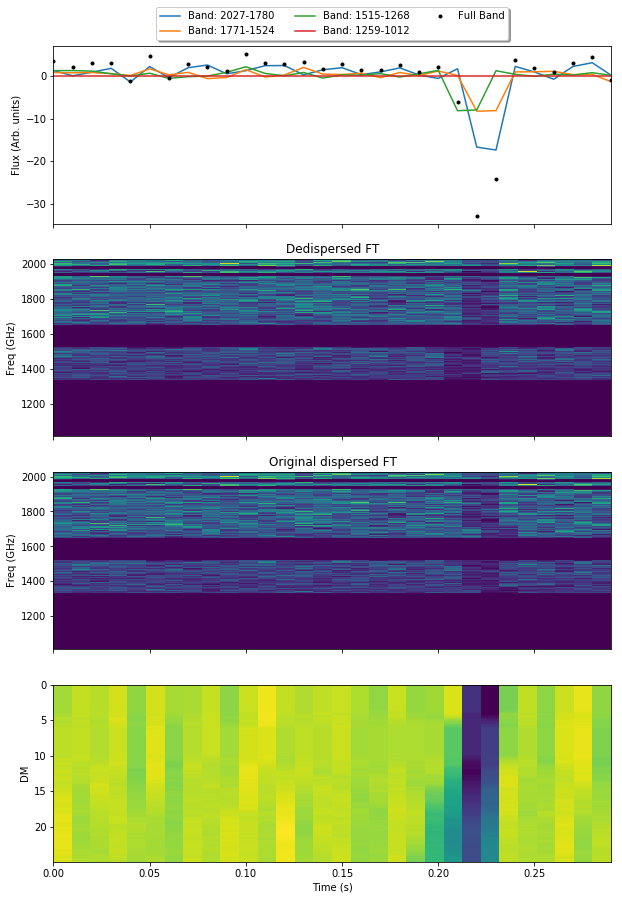

In [8]:
# Read the pickle file just generated, and generate the refinement plots for all candidates
pklname = 'cands_'+cc.metadata.scanId +'.pkl'
cds = list(rfpipe.candidates.iter_cands(pklname, select='canddata'))
for i in range(len(cds)):
    cd = cds[i]
    make_refinement_plots(cd)